In [15]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# Removed: from scipy.interpolate import RectBivariateSpline

# Optional: Set matplotlib backend for inline display in Jupyter
%matplotlib inline




In [13]:
# Replace with the actual paths to the files generated by your script (run on 18 lines)
hdf5_path = "/home/elie/Projects/Work/chromatogram_extraction/test_results/output.hdf5"
metadata_csv_path = "/home/elie/Projects/Work/chromatogram_extraction/test_results/output_metadata.csv"
upscale_factor = 4

In [8]:
output_pdf_path = None

In [9]:
print(f"Reading metadata from: {metadata_csv_path}")
try:
    metadata_df = pd.read_csv(metadata_csv_path)
    if metadata_df.empty:
        print("Metadata CSV is empty. Cannot proceed.")
        # Stop execution if needed in a notebook
        raise SystemExit("Metadata CSV empty")
    print(f"Found {len(metadata_df)} entries in metadata CSV.")
except FileNotFoundError:
    print(f"Error: Metadata CSV file not found at '{metadata_csv_path}'")
    raise SystemExit("CSV not found")
except Exception as e:
    print(f"Error reading metadata CSV '{metadata_csv_path}': {e}")
    raise SystemExit("CSV read error")

print(f"Preparing to read HDF5 file: {hdf5_path}")
if not os.path.exists(hdf5_path):
     print(f"Error: HDF5 file not found at '{hdf5_path}'")
     raise SystemExit("HDF5 not found")


# Setup PDF output if specified
pdf = None
if output_pdf_path:
    try:
        output_dir = os.path.dirname(output_pdf_path)
        if output_dir and not os.path.exists(output_dir):
             os.makedirs(output_dir)
             print(f"Created output directory: {output_dir}")
        pdf = PdfPages(output_pdf_path)
        print(f"Will save visualizations to PDF: {output_pdf_path}")
    except Exception as e:
        print(f"Error: Could not create PDF file at '{output_pdf_path}'. Plots will be shown inline. Error: {e}")
        output_pdf_path = None # Revert to inline display

print("-" * 20)

Reading metadata from: /home/elie/Projects/Work/chromatogram_extraction/test_results/output_metadata.csv
Found 18 entries in metadata CSV.
Preparing to read HDF5 file: /home/elie/Projects/Work/chromatogram_extraction/test_results/output.hdf5
--------------------


Opened HDF5 file: /home/elie/Projects/Work/chromatogram_extraction/test_results/output.hdf5
Processing 1/18: 001227_J0_PH_1/patch_57915f8e-56b5-421c-9a8e-e880417933d7
Processing 2/18: 001227_J0_PH_1/patch_6f7b9fba-7a41-44f3-80a3-0eff01280c45
Processing 3/18: 001227_J0_PH_1/patch_3b8d6399-d1ca-45dc-aa84-146b5e01ccc4
Processing 4/18: 001227_J0_PH_1/patch_540b4ba2-8724-4084-abb8-bdcd13f31843
Processing 5/18: 001227_J0_PH_1/patch_2c560389-4c98-4d85-bd7b-686d9b9069fe
Processing 6/18: 001227_J0_PH_1/patch_6420b659-a155-48e5-b705-4741a20d61ce
Processing 7/18: 001227_J0_PH_1/patch_2cbcbaba-d0fd-4269-bf0d-d6f1fc97a05b
Processing 8/18: 001227_J0_PH_1/patch_72906cc4-1f5d-4e1b-a7ec-5856ebfeaba8
Processing 9/18: 001227_J0_PH_1/patch_5704cc27-39ac-43a1-8790-687737f568d5
Processing 10/18: 001241_J0_PH_1/patch_9f2a73c9-6126-43c1-a25f-7c28b414f883
Processing 11/18: 001241_J0_PH_1/patch_6313b370-a74c-4bfc-896b-b59f3234cda5
Processing 12/18: 001241_J0_PH_1/patch_f2f801c8-360c-4f2d-97b2-21c85b01b8ad
Proce

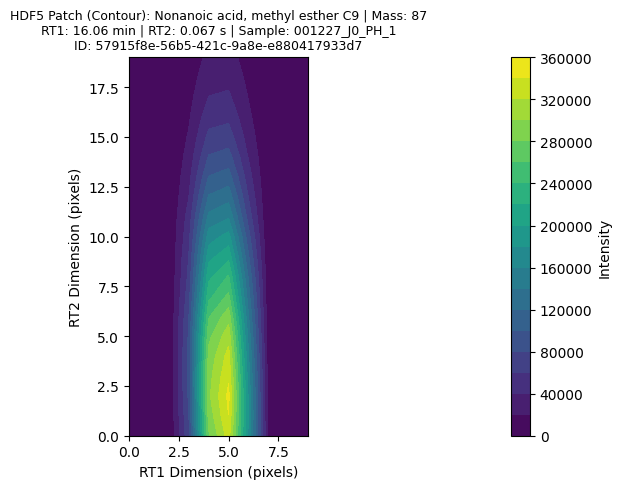

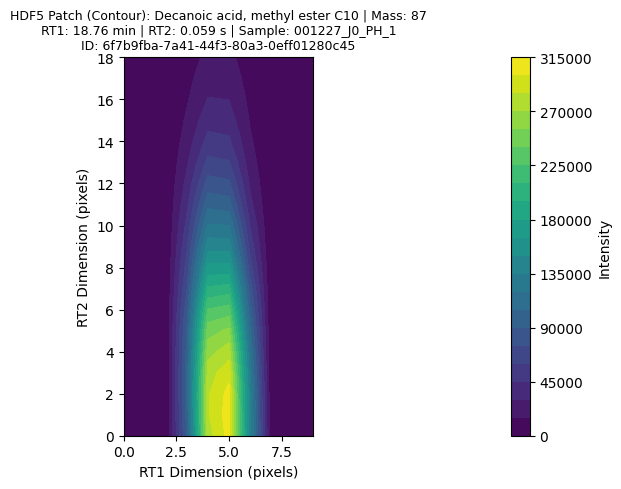

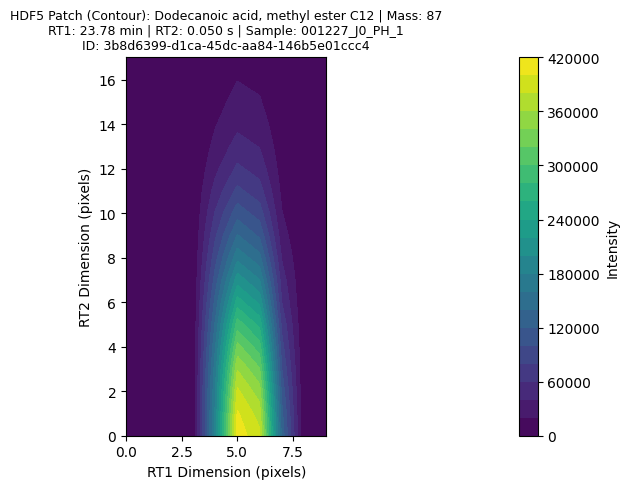

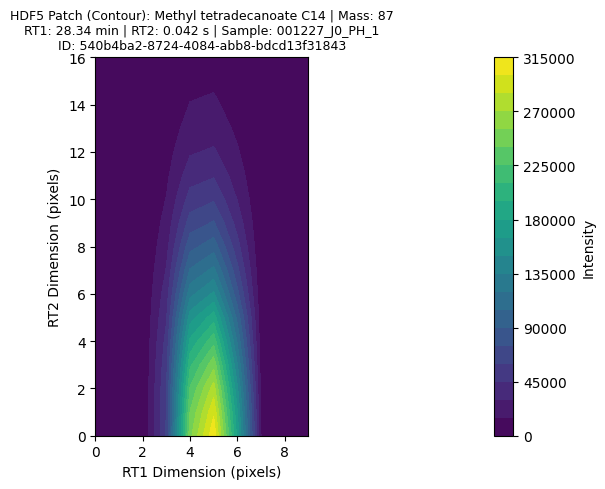

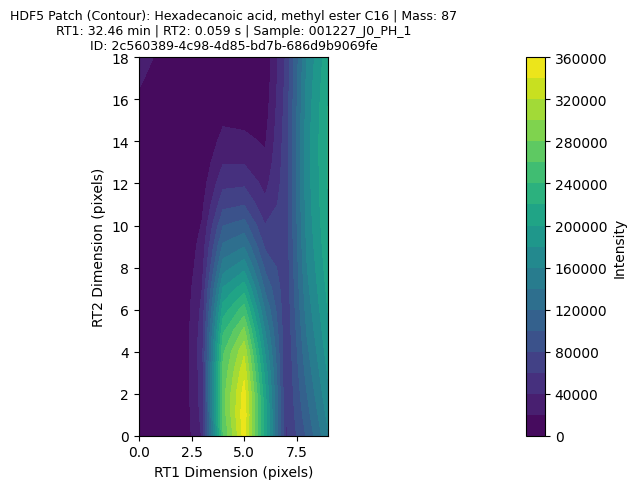

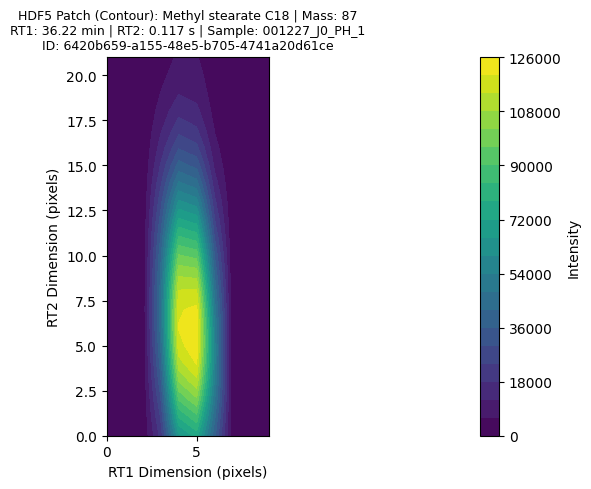

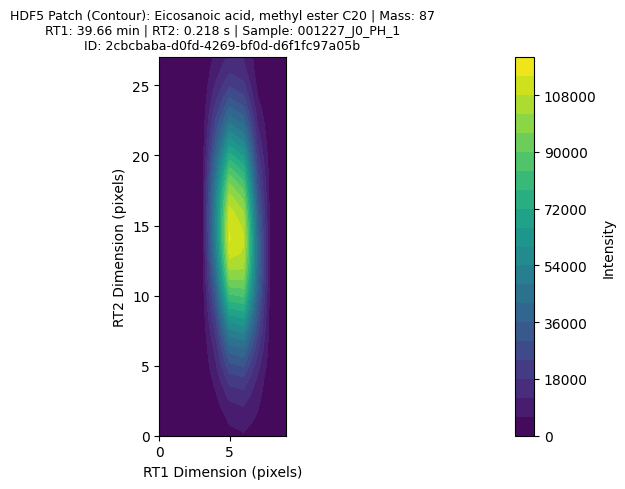

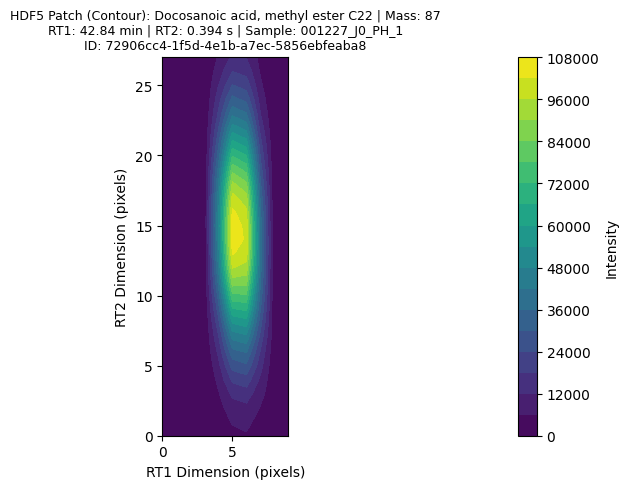

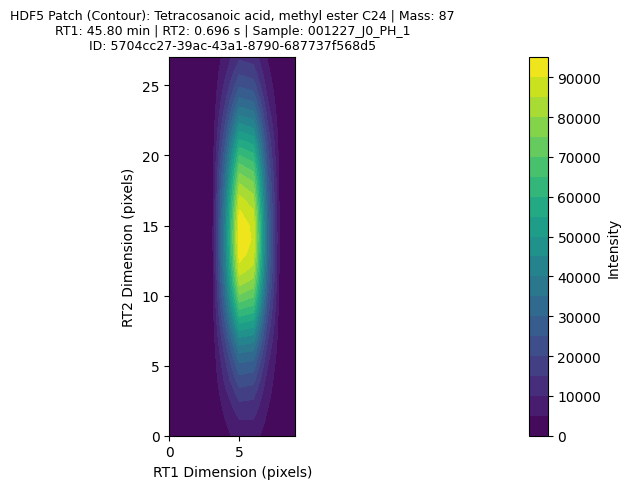

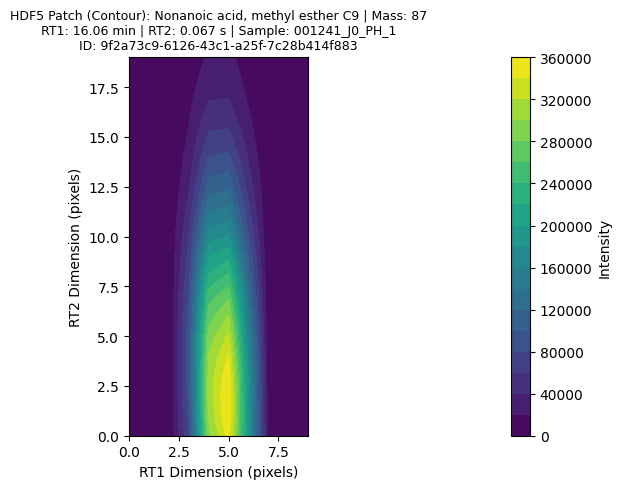

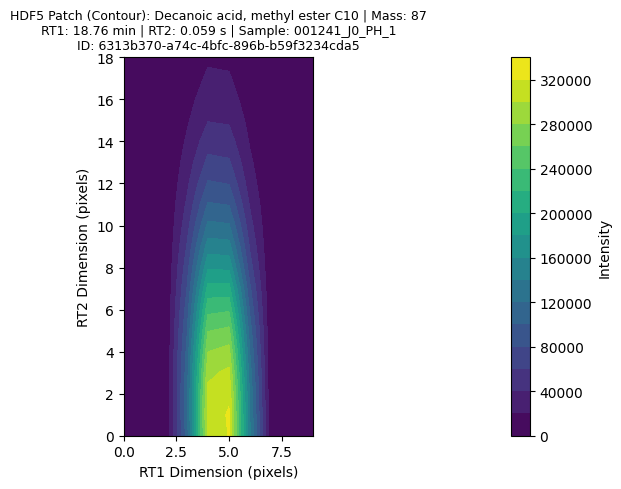

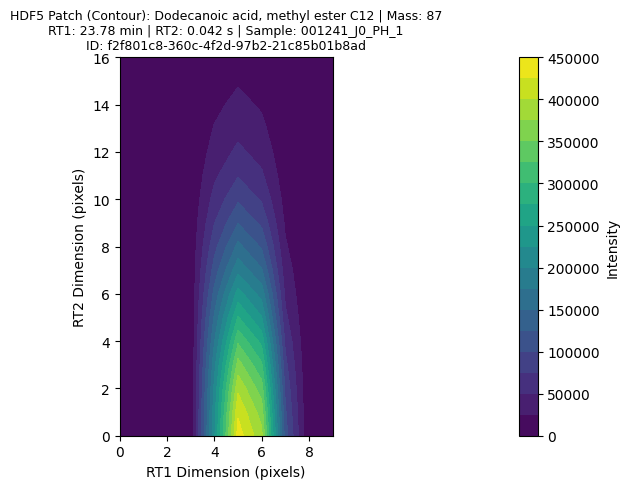

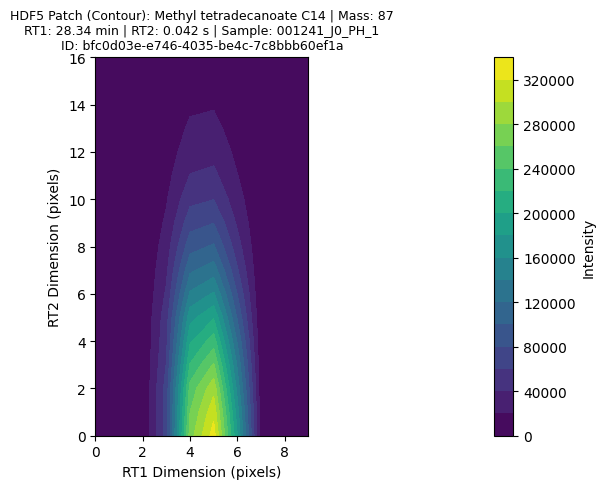

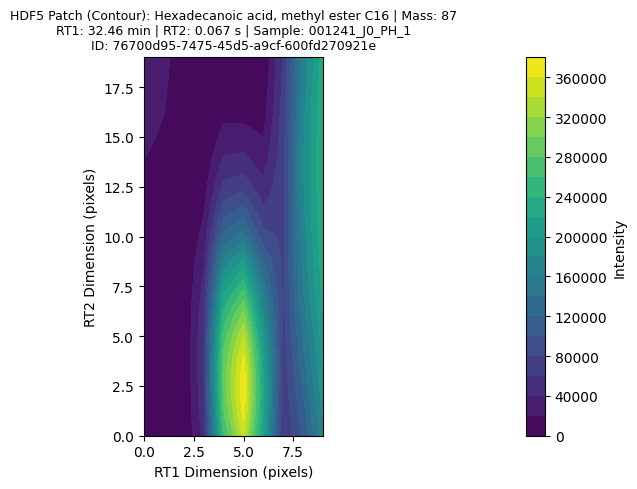

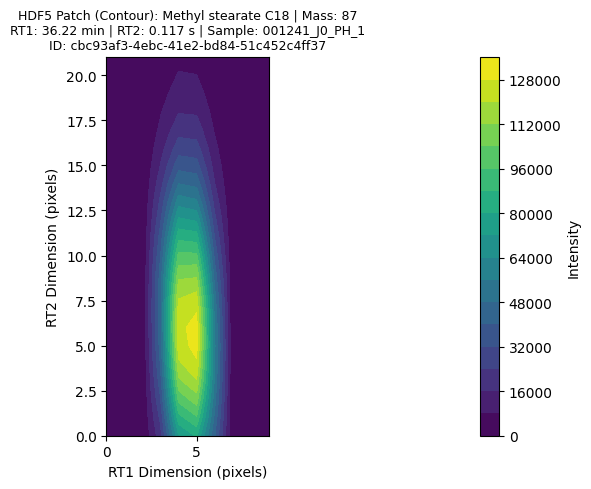

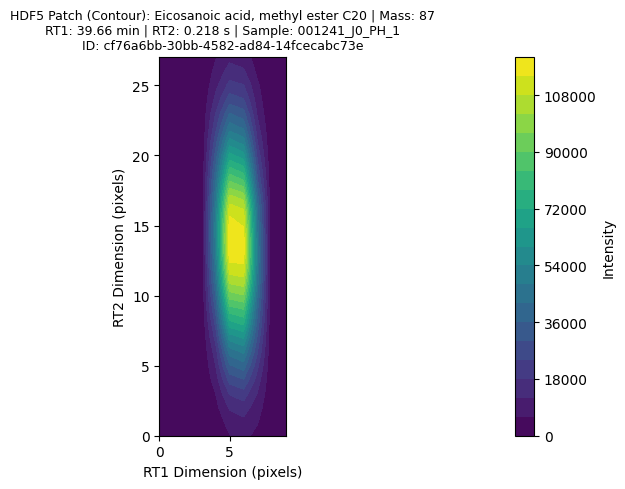

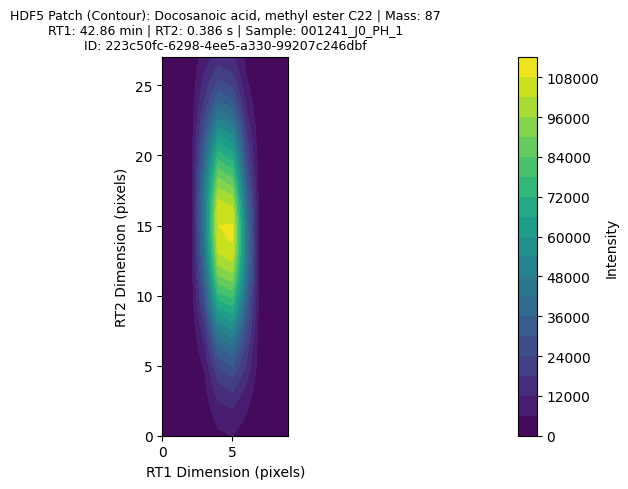

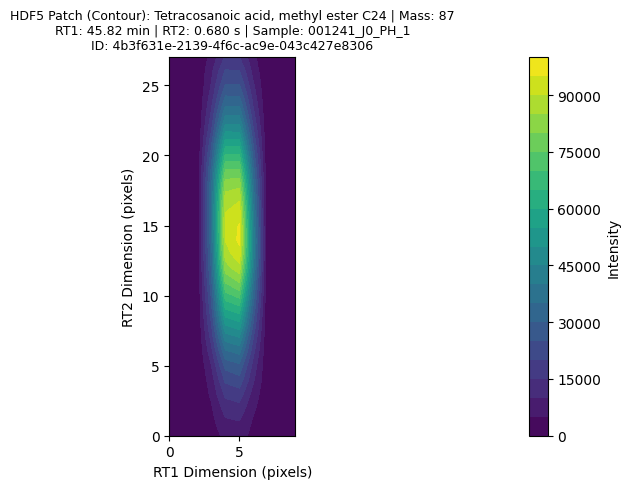

In [16]:
num_processed = 0
num_errors = 0

# Use 'with' statement for safer file handling
with h5py.File(hdf5_path, 'r') as h5_file:
    print(f"Opened HDF5 file: {hdf5_path}")
    for index, row in metadata_df.iterrows():
        try:
            sample_name = row['Sample']
            peak_name = row['Mol']
            mass = row['mass']
            rt1 = row['RT1_corrected']
            rt2 = row['RT2_corrected']
            patch_id = row['patch_id']
            unique_id = row['unique_id']

            if pd.isna(patch_id) or not patch_id:
                print(f"Skipping row {index+1}: Missing or invalid patch_id ('{patch_id}').")
                continue

            dataset_path = f"{sample_name}/{patch_id}"
            print(f"Processing {index+1}/{len(metadata_df)}: {dataset_path}")

            if dataset_path not in h5_file:
                 print(f"  Error: Dataset not found at path '{dataset_path}'.")
                 num_errors += 1
                 continue

            patch_data = h5_file[dataset_path][()]

            if patch_data is None or patch_data.size == 0:
                print("  Warning: Patch data is empty. Skipping visualization.")
                continue

            # --- Visualize using contourf ---
            fig, ax = plt.subplots(figsize=(7, 5))

            plot_data = patch_data.T # Transpose for RT1 on x-axis

            # Use contourf on the data. It will use array indices for axes.
            # Specify levels or let contourf choose them. Add more levels for finer detail.
            levels = 20 # Example: Number of contour levels
            contour_plot = ax.contourf(plot_data, levels=levels, cmap='viridis')

            fig.colorbar(contour_plot, ax=ax, label='Intensity')
            title = f"HDF5 Patch (Contour): {peak_name} | Mass: {mass}\nRT1: {rt1:.2f} min | RT2: {rt2:.3f} s | Sample: {sample_name}\nID: {unique_id}"
            ax.set_title(title, fontsize=9)
            # Axes now represent pixel indices of the transposed clipped patch
            ax.set_xlabel("RT1 Dimension (pixels)")
            ax.set_ylabel("RT2 Dimension (pixels)")
            # Ensure axes limits match data dimensions if needed (contourf might autoscale)
            ax.axis('image') # Set aspect ratio to equal to avoid distortion
            fig.tight_layout()

            if pdf:
                pdf.savefig(fig) # Save the current figure to PDF
                print(f"  Added plot for {peak_name} to PDF.")
                plt.close(fig) # Close figure ONLY if saving to PDF
            else:
                # Let Jupyter display the plot inline
                pass

            num_processed += 1

        except KeyError as e:
            print(f"  Skipping row {index+1} due to missing column in CSV: {e}")
            num_errors += 1
        except Exception as e:
            print(f"  An unexpected error occurred processing row {index+1} ('{peak_name}'): {e}")
            num_errors += 1
            plt.close('all')

# --- Cleanup for PDF ---
if pdf:
    pdf.close()
    print(f"\nFinished writing PDF: {output_pdf_path}")

print(f"\nVisualization complete. Processed: {num_processed}, Errors/Skipped: {num_errors}")